In [9]:
import pykat
from pykat import finesse
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline
pykat.init_pykat_plotting(dpi=90)

# PRFPMI Model

In [10]:
base = finesse.kat()
base.verbose=False
base.parse("""

# ======== Constants ========================
const f1 16.881M
const f2 45.0159M
const mf1 -16.881M
const mf2 -45.0159M
const a 0.686

# ======== Input optics =====================
l i1 1 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 $f1 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 $f2 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 nREFL

## ======= PRC each mirror loss 45ppm =======
m1 PRM 0.1 0 0 nREFL npr1
s sLpr1 14.7615 npr1 npr2
bs1 PR2 500e-6 0 0 $a npr3 npr2 nPOP nPOP2
s sLpr2 11.0661 npr3 npr4
#bs1 PR3 50e-6 0 0 $a dump dump npr4 npr5
bs1 PR3 0 0 0 $a npr4 npr5 dump dump 
s sLpr3 15.7638 npr5 npr6

# Michelson
bs bs1 0.5 0.5 0 45 npr6 n2 n3 nAS
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1

# X arm
m ITMX 0.996 0.004 0 nx1 nx2
s sx1 3000 nx2 nx3
m ETMX 0.999995 5e-06 0 nx3 nTMSX

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2
s sy1 3000 ny2 ny3
m ETMY 0.999995 5e-06 90 ny3 nTMSY

## ===== amplitude detectors =====

ad CR_POP 0 nPOP
ad SB1p_POP $f1 nPOP
ad SB1m_POP $mf1 nPOP
ad SB2p_POP $f2 nPOP
ad SB2m_POP $mf2 nPOP

ad CR_TMSX 0_TMSX nTMSX
ad SB1p_TMSX $f1 nTMSX
ad SB1m_TMSX $mf1 nTMSX
ad SB2p_TMSX $f2 nTMSX
ad SB2m_TMSX $mf2 nTMSX



""")

## Field Check (PRC tune, ETMX tune)

<function matplotlib.pyplot.show(*args, **kw)>

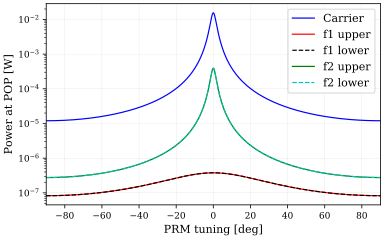

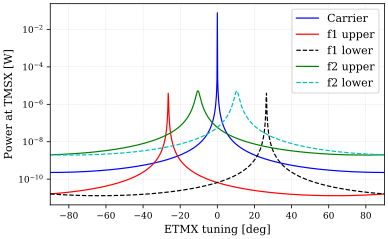

In [11]:
kat0 = base.deepcopy()
kat0.parse("""
xaxis* PRM phi lin -90 90 1000
""")

out = kat0.run()
plt.figure(1)
plt.semilogy(out.x, out["CR_POP"]**2,label="Carrier")
plt.semilogy(out.x, out["SB1p_POP"]**2,label="f1 upper")
plt.semilogy(out.x, out["SB1m_POP"]**2,label="f1 lower",LineStyle='--')
plt.semilogy(out.x, out["SB2p_POP"]**2,label="f2 upper")
plt.semilogy(out.x, out["SB2m_POP"]**2,label="f2 lower",LineStyle='--')
plt.xlabel("PRM tuning [deg]")
plt.ylabel("Power at POP [W]")
plt.legend(loc=1)
plt.show

kat1 = base.deepcopy()
kat1.parse("""
xaxis* ETMX phi lin -90 90 1000
""")

out1 = kat1.run()

plt.figure(2)
plt.semilogy(out.x, out1["CR_TMSX"]**2,label="Carrier")
plt.semilogy(out.x, out1["SB1p_TMSX"]**2,label="f1 upper")
plt.semilogy(out.x, out1["SB1m_TMSX"]**2,label="f1 lower",LineStyle='--')
plt.semilogy(out.x, out1["SB2p_TMSX"]**2,label="f2 upper")
plt.semilogy(out.x, out1["SB2m_TMSX"]**2,label="f2 lower",LineStyle='--')
plt.xlabel("ETMX tuning [deg]")
plt.ylabel("Power at TMSX [W]")
plt.legend(loc=1)
plt.show



## Sensing Matrix (fsig)
### f1

In [12]:
DARM = base.deepcopy()
DARM.parse("""
const f1 16.881M
const fstart 0.001
const fend 10

fsig sig1 ETMX 10 0
fsig sig1 ETMY 10 180
xaxis sig1 f log $fstart $fend 200

pd2 ASQ1 $f1 213 10 nAS
pd2 REFLI1 $f1 0 10 nREFL
pd2 REFLQ1 $f1 90 10 nREFL
pd2 POPI1 $f1 119 10 nPOP
pd2 POPQ1 $f1 209 10 nPOP

put ASQ1 f2 $x1
put REFLI1 f2 $x1
put REFLQ1 f2 $x1
put POPI1 f2 $x1
put POPQ1 f2 $x1

yaxis lin abs:deg

""")
out = DARM.run()

print("DARM")
print(np.sign(np.sin(np.angle(out["ASQ1"][0])))* np.abs(out["ASQ1"][0]))
print(np.sign(np.sin(np.angle(out["REFLI1"][0])))* np.abs(out["REFLI1"][0]))
print(np.sign(np.sin(np.angle(out["REFLQ1"][0])))* np.abs(out["REFLQ1"][0]))
print(np.sign(np.sin(np.angle(out["POPI1"][0])))* np.abs(out["POPI1"][0]))
print(np.sign(np.sin(np.angle(out["POPQ1"][0])))* np.abs(out["POPQ1"][0]))

MICH = base.deepcopy()
MICH.parse("""
const f1 16.881M
const fstart 0.001
const fend 10

fsig sig1 ITMX 10 0
fsig sig1 ETMX 10 0
fsig sig1 ITMY 10 180
fsig sig1 ETMY 10 180

xaxis sig1 f log $fstart $fend 200

pd2 ASQ1 $f1 213 10 nAS
pd2 REFLI1 $f1 0 10 nREFL
pd2 REFLQ1 $f1 90 10 nREFL
pd2 POPI1 $f1 119 10 nPOP
pd2 POPQ1 $f1 209 10 nPOP

put ASQ1 f2 $x1
put REFLI1 f2 $x1
put REFLQ1 f2 $x1
put POPI1 f2 $x1
put POPQ1 f2 $x1

yaxis lin abs:deg

""")
del out
out = MICH.run()

print("MICH")
print(np.sign(np.sin(np.angle(out["ASQ1"][0])))* np.abs(out["ASQ1"][0]))
print(np.sign(np.sin(np.angle(out["REFLI1"][0])))* np.abs(out["REFLI1"][0]))
print(np.sign(np.sin(np.angle(out["REFLQ1"][0])))* np.abs(out["REFLQ1"][0]))
print(np.sign(np.sin(np.angle(out["POPI1"][0])))* np.abs(out["POPI1"][0]))
print(np.sign(np.sin(np.angle(out["POPQ1"][0])))* np.abs(out["POPQ1"][0]))

CARM = base.deepcopy()
CARM.parse("""
const f1 16.881M
const fstart 0.001
const fend 10

fsig sig1 ETMX 10 0
fsig sig1 ETMY 10 0
xaxis sig1 f log $fstart $fend 200

pd2 ASQ1 $f1 213 10 nAS
pd2 REFLI1 $f1 0 10 nREFL
pd2 REFLQ1 $f1 90 10 nREFL
pd2 POPI1 $f1 119.21 10 nPOP
pd2 POPQ1 $f1 209.21 10 nPOP

put ASQ1 f2 $x1
put REFLI1 f2 $x1
put REFLQ1 f2 $x1
put POPI1 f2 $x1
put POPQ1 f2 $x1

yaxis lin abs:deg

""")
del out
out = CARM.run()

print("CARM")
print(np.sign(np.sin(np.angle(out["ASQ1"][0])))* np.abs(out["ASQ1"][0]))
print(np.sign(np.sin(np.angle(out["REFLI1"][0])))* np.abs(out["REFLI1"][0]))
print(np.sign(np.sin(np.angle(out["REFLQ1"][0])))* np.abs(out["REFLQ1"][0]))
print(np.sign(np.sin(np.angle(out["POPI1"][0])))* np.abs(out["POPI1"][0]))
print(np.sign(np.sin(np.angle(out["POPQ1"][0])))* np.abs(out["POPQ1"][0]))

PRCL = base.deepcopy()
PRCL.parse("""
const f1 16.881M
const fstart 0.001
const fend 10

fsig sig1 PRM 10 0
xaxis sig1 f log $fstart $fend 200

pd2 ASQ1 $f1 213 10 nAS
pd2 REFLI1 $f1 0 10 nREFL
pd2 REFLQ1 $f1 90 10 nREFL
pd2 POPI1 $f1 119.21 10 nPOP
pd2 POPQ1 $f1 209.21 10 nPOP

put ASQ1 f2 $x1
put REFLI1 f2 $x1
put REFLQ1 f2 $x1
put POPI1 f2 $x1
put POPQ1 f2 $x1

yaxis lin abs:deg

""")
del out
out = PRCL.run()

print("PRCL")
print(np.sign(np.sin(np.angle(out["ASQ1"][0])))* np.abs(out["ASQ1"][0]))
print(np.sign(np.sin(np.angle(out["REFLI1"][0])))* np.abs(out["REFLI1"][0]))
print(np.sign(np.sin(np.angle(out["REFLQ1"][0])))* np.abs(out["REFLQ1"][0]))
print(np.sign(np.sin(np.angle(out["POPI1"][0])))* np.abs(out["POPI1"][0]))
print(np.sign(np.sin(np.angle(out["POPQ1"][0])))* np.abs(out["POPQ1"][0]))



DARM
1476.94429375625
6.25360108872228e-07
0.000573214314973118
2.18086745613464e-08
5.91587819403335e-06
MICH
1.4799032846908098
4.354986587081759e-05
-0.112531889727605
4.28706086529074e-06
0.00116138924238346
CARM
1.8517794649104703e-06
16713.7434344774
0.320637359431363
5.648678393534639
0.00072955577284297
PRCL
-1.80385030817016e-09
-16.793842590344298
-0.000303240160172217
-0.00517891179273794
-7.18454801426993e-07


(0.0001, 100)

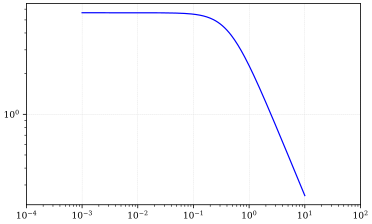

In [153]:
CARM = base.deepcopy()
CARM.parse("""
const f1 16.881M
const fstart 0.001
const fend 10

fsig sig1 ETMX 10 0
fsig sig1 ETMY 10 0
xaxis sig1 f log $fstart $fend 200

pd2 ASQ1 $f1 213 10 nAS
pd2 REFLI1 $f1 0 10 nREFL
pd2 REFLQ1 $f1 90 10 nREFL
pd2 POPI1 $f1 119.21 10 nPOP
pd2 POPQ1 $f1 209.21 10 nPOP

put ASQ1 f2 $x1
put REFLI1 f2 $x1
put REFLQ1 f2 $x1
put POPI1 f2 $x1
put POPQ1 f2 $x1

yaxis lin abs:deg

""")
del out
out = CARM.run()
plt.loglog(out.x, np.abs(out["POPI1"]))
plt.xlim(0.0001,100)


### f2

In [13]:
DARM = base.deepcopy()
DARM.parse("""
const f1 45.0159M

fsig sig1 ETMX 10 0
fsig sig1 ETMY 10 180
xaxis sig1 f log .001 100 500

pd2 ASQ2 $f1 178 10 nAS
pd2 REFLI2 $f1 0 10 nREFL
pd2 REFLQ2 $f1 90 10 nREFL
pd2 POPI2 $f1 74 10 nPOP
pd2 POPQ2 $f1 164 10 nPOP

put ASQ2 f2 $x1
put REFLI2 f2 $x1
put REFLQ2 f2 $x1
put POPI2 f2 $x1
put POPQ2 f2 $x1

yaxis lin abs:deg

""")
del out
out = DARM.run()

print("DARM")
print(np.sign(np.sin(np.angle(out["ASQ2"][0])))* np.abs(out["ASQ2"][0]))
print(np.sign(np.sin(np.angle(out["REFLI2"][0])))* np.abs(out["REFLI2"][0]))
print(np.sign(np.sin(np.angle(out["REFLQ2"][0])))* np.abs(out["REFLQ2"][0]))
print(np.sign(np.sin(np.angle(out["POPI2"][0])))* np.abs(out["POPI2"][0]))
print(np.sign(np.sin(np.angle(out["POPQ2"][0])))* np.abs(out["POPQ2"][0]))

MICH = base.deepcopy()
MICH.parse("""
const f1 45.0159M

fsig sig1 ITMX 10 0
fsig sig1 ETMX 10 0
fsig sig1 ITMY 10 180
fsig sig1 ETMY 10 180

xaxis sig1 f log .001 100 500

pd2 ASQ2 $f1 178 10 nAS
pd2 REFLI2 $f1 0 10 nREFL
pd2 REFLQ2 $f1 90 10 nREFL
pd2 POPI2 $f1 74 10 nPOP
pd2 POPQ2 $f1 164 10 nPOP

put ASQ2 f2 $x1
put REFLI2 f2 $x1
put REFLQ2 f2 $x1
put POPI2 f2 $x1
put POPQ2 f2 $x1

yaxis lin abs:deg

""")
del out
out = MICH.run()

print("MICH")
print(np.sign(np.sin(np.angle(out["ASQ2"][0])))* np.abs(out["ASQ2"][0]))
print(np.sign(np.sin(np.angle(out["REFLI2"][0])))* np.abs(out["REFLI2"][0]))
print(np.sign(np.sin(np.angle(out["REFLQ2"][0])))* np.abs(out["REFLQ2"][0]))
print(np.sign(np.sin(np.angle(out["POPI2"][0])))* np.abs(out["POPI2"][0]))
print(np.sign(np.sin(np.angle(out["POPQ2"][0])))* np.abs(out["POPQ2"][0]))

CARM = base.deepcopy()
CARM.parse("""
const f1 45.0159M

fsig sig1 ETMX 10 0
fsig sig1 ETMY 10 0
xaxis sig1 f log .001 100 500

pd2 ASQ2 $f1 178 10 nAS
pd2 REFLI2 $f1 -0.3 10 nREFL
pd2 REFLQ2 $f1 89.7 10 nREFL
pd2 POPI2 $f1 77.5 10 nPOP
pd2 POPQ2 $f1 167.5 10 nPOP

put ASQ2 f2 $x1
put REFLI2 f2 $x1
put REFLQ2 f2 $x1
put POPI2 f2 $x1
put POPQ2 f2 $x1

yaxis lin abs:deg

""")
del out
out = CARM.run()

print("CARM")
print(np.sign(np.sin(np.angle(out["ASQ2"][0])))* np.abs(out["ASQ2"][0]))
print(np.sign(np.sin(np.angle(out["REFLI2"][0])))* np.abs(out["REFLI2"][0]))
print(np.sign(np.sin(np.angle(out["REFLQ2"][0])))* np.abs(out["REFLQ2"][0]))
print(np.sign(np.sin(np.angle(out["POPI2"][0])))* np.abs(out["POPI2"][0]))
print(np.sign(np.sin(np.angle(out["POPQ2"][0])))* np.abs(out["POPQ2"][0]))


DARM
-0.936947420038368
-6.59437321767768e-07
2.61495066750459e-05
-1.8276910708893702e-08
-2.69337662204172e-07
MICH
-0.0009388245517159739
-4.73540300152496e-06
0.000878187448649498
5.76324926681178e-07
9.045214669951952e-06
CARM
-1.17473624395574e-09
-18453.6483337803
3.83592021223296
-181.56758671048797
-0.938344928551435


PRCL
1.1443688260669804e-13
0.0583734883007524
-0.0009644525816095631
0.00831352516807631
9.38562895685183e-05


(1e-05, 1000)

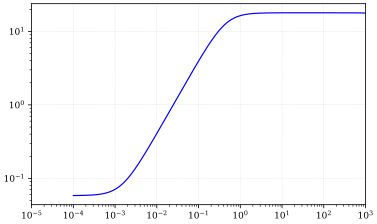

In [19]:
PRCL = base.deepcopy()
PRCL.parse("""
const f1 45.0159M

fsig sig1 PRM 0.0001 0
xaxis sig1 f log .0001 1000 800

pd2 ASQ2 $f1 178 0.00001 nAS
pd2 REFLI2 $f1 -0.3 0.00001 nREFL
pd2 REFLQ2 $f1 89.7 0.00001 nREFL
pd2 POPI2 $f1 75 0.00001 nPOP
pd2 POPQ2 $f1 165 0.00001 nPOP

put ASQ2 f2 $x1
put REFLI2 f2 $x1
put REFLQ2 f2 $x1
put POPI2 f2 $x1
put POPQ2 f2 $x1

yaxis lin abs:deg

""")
del out
out = PRCL.run()

print("PRCL")
print(np.sign(np.sin(np.angle(out["ASQ2"][0])))* np.abs(out["ASQ2"][0]))
print(np.sign(np.sin(np.angle(out["REFLI2"][0])))* np.abs(out["REFLI2"][0]))
print(np.sign(np.sin(np.angle(out["REFLQ2"][0])))* np.abs(out["REFLQ2"][0]))
print(np.sign(np.sin(np.angle(out["POPI2"][0])))* np.abs(out["POPI2"][0]))
print(np.sign(np.sin(np.angle(out["POPQ2"][0])))* np.abs(out["POPQ2"][0]))

plt.loglog(out.x, np.abs(out["REFLI2"]))
plt.xlim(0.00001,1000)

### Parameter Check

In [20]:
param_check = base.deepcopy()
param_check.parse("""
const f1 16.881M
const f2 45.0159M

ad CR_in 0 nREFL*
ad SB1p_in $f1 nREFL*
ad SB2p_in $f2 nREFL*

ad CR_out 0 nREFL
ad SB1p_out $f1 nREFL
ad SB2p_out $f2 nREFL


ad CR_prc 0 npr1
ad SB1p_prc $f1 npr1
ad SB2p_prc $f2 npr1

xaxis PRM phi lin -1 1 2
yaxis lin abs
""")

result = param_check.run()

g0 = result["CR_prc"]/result["CR_in"]
g1 = result["SB1p_prc"]/result["SB1p_in"]
g2 = result["SB2p_prc"]/result["SB1p_in"]

rec0 = result["CR_out"]/result["CR_in"]
rec1 = result["SB1p_out"]/result["SB1p_in"]
rec2 = result["SB2p_out"]/result["SB1p_in"]


print(g0[1])
print(g1[1])
print(g2[1])

print("  ")
print(rec0[1])
print(rec1[1])
print(rec2[1])




5.839429439064074
0.49633723255559903
6.1058082243889364
  
0.8923839262985651
0.8886468102461019
0.981184384629797
